<a href="https://colab.research.google.com/github/K-Wolfe-hub/spds_Capstone_2/blob/main/Capstone_2_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import tree, metrics

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Loading 2 datasets that have been split into training and test. \\
The first dataset with "val" in it's names will be used for modeling property values. This dataset has all of the value related data removed from the X dataframe to prevent autocorrolation. This dataset focuses on descriptive information about the property such as land/building size, building features, and geographic scaling factors generated in the EDA portion of the project. \\
The second dataset with "hear" in its names contains the information from the previous dataset along with value information such as the previous apprasal value.

In [ ]:
#read the preprocessed and scaled data from the data folder
X_hear_train_scaled_df = pd.read_csv('gdrive/My Drive/Springboard Capstone 2/HCAD_Data/X_hear_train.csv')
X_hear_test_scaled_df = pd.read_csv('gdrive/My Drive/Springboard Capstone 2/HCAD_Data/X_hear_test.csv')
y_hear_train_df = pd.read_csv('gdrive/My Drive/Springboard Capstone 2/HCAD_Data/y_hear_train.csv')
y_hear_test_df = pd.read_csv('gdrive/My Drive/Springboard Capstone 2/HCAD_Data/y_hear_test.csv')
X_val_train_scaled_df = pd.read_csv('gdrive/My Drive/Springboard Capstone 2/HCAD_Data/X_val_train.csv')
X_val_test_scaled_df = pd.read_csv('gdrive/My Drive/Springboard Capstone 2/HCAD_Data/X_val_test.csv')
y_val_train_df = pd.read_csv('gdrive/My Drive/Springboard Capstone 2/HCAD_Data/y_val_train.csv')
y_val_test_df = pd.read_csv('gdrive/My Drive/Springboard Capstone 2/HCAD_Data/y_val_test.csv')
X_hear_train_scaled_df.head(2)

,Unnamed: 0,bld_ar,land_ar,land_val,bld_val,x_features_val,assessed_val,tot_appr_val,tot_mkt_val,prior_land_val,prior_bld_val,prior_x_features_val,prior_tot_appr_val,prior_tot_mkt_val,new_construction_val,tot_rcn_val,Initial_Appraised_Value,Initial_Market_Value,ATR,FPD,FPM,FPO,FPW,FXA,FXT,LLR,MAS,REL,RMB,RMF,RMH,RMR,RMT,STY,land_factor_school_dist,land_factor_Neighborhood_Code,land_factor_Neighborhood_Grp,land_factor_Market_Area_1,land_factor_Market_Area_2,land_factor_center_code,bld_val_per_ft2,bld_factor_school_dist,bld_factor_Neighborhood_Code,bld_factor_Neighborhood_Grp,bld_factor_Market_Area_1,bld_factor_Market_Area_2,bld_factor_center_code,tot_appr_val_inc,Cap_acct_Y,shared_cad_Y,Hearing_Type_I,Hearing_Type_N,Hearing_Type_R,Agent_Code_Owner
0,0,-0.198729,-0.064149,0.163018,-0.586545,-0.294732,-0.203413,-0.190070,-0.203413,-0.054234,-0.300174,-0.296894,-0.176344,-0.191791,-0.107074,-0.466713,-0.198286,-0.212132,-0.03427,-0.181033,-0.694627,-0.061943,-0.482345,-0.820298,-0.601415,-0.007258,-0.189942,-0.060566,-0.429853,-0.094383,-0.840306,-0.697435,-1.060878,-0.728107,2.344139,0.091039,0.009446,0.750158,0.674328,1.401085,-1.227358,1.304960,-1.175675,-0.938148,-0.253086,-0.388709,0.673680,-0.193751,-0.541382,-0.303931,-0.441201,0.60702,-0.001679,-0.463422
1,1,0.494313,-0.245681,-0.182272,-0.233828,-0.294732,-0.237433,-0.427737,-0.237433,-0.209520,-0.212018,-0.296894,-0.429101,-0.243659,-0.107074,0.354437,-0.426822,-0.244496,-0.03427,-0.181033,-0.694627,-0.061943,-0.482345,0.428047,-0.113422,-0.007258,-0.189942,-0.060566,0.753266,-0.094383,-0.840306,-0.697435,0.625780,0.937108,1.296938,-0.085572,0.082472,0.435841,0.284880,-0.235599,-0.834574,-0.336423,-0.787298,-1.096563,-0.214499,-0.616618,-1.757294,-0.121074,1.847124,-0.303931,-0.441201,0.60702,-0.001679,-0.463422


In [ ]:
X_hear_train_scaled_df.shape

(709393, 50)

# Total Appriasal Values prediction

## Simple linear Model with default parameters

Initial model for valuation will be just a linear model with the full "val" dataset. This is run with the default parameters.

In [ ]:
#Simple linear model to develop a baseline
rModel = linear_model.LinearRegression()
rModel.fit(X_val_train_scaled_df,y_val_train_df['tot_appr_val'])
rModel.score(X_val_train_scaled_df,y_val_train_df['tot_appr_val'])

0.7800303041887412

In [ ]:
y_val_pred = rModel.predict(X_val_test_scaled_df)

In [ ]:
print('Root Mean Squared Error for this model is: '+str(mean_squared_error(y_val_test_df['tot_appr_val'],y_val_pred, squared=False)))

Root Mean Squared Error for this model is: 4352300.166354265


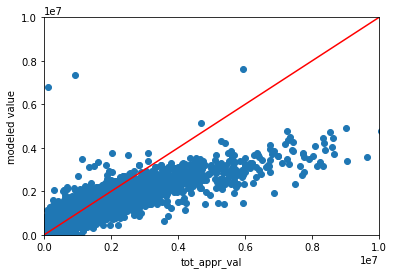

In [ ]:
# Let's plot the predictions against the actual result. Use scatter()
plt.scatter(y_val_test_df['tot_appr_val'],y_val_pred)
plt.ylim(0,10000000)
plt.xlim(0,10000000)
plt.xlabel('tot_appr_val')
plt.ylabel('modeled value')
plt.plot([3,1000000,25000000],[3,1000000,25000000],color='red')
plt.show()

It looks like this model falls apart for higher value properties. I don't think this model is the best I can do.

## Simple Ridge Regression model with default parameters

Next I am going to use Ridge Regression to see if I can improve this model. I am attempting Ridge as some of the area factors that I created could be corrolated and this method should handel this better.

In [ ]:
#lets try something a bit more flexible
ridg = linear_model.Ridge(random_state=42)
ridg.fit(X_val_train_scaled_df,y_val_train_df['tot_appr_val'])
ridg.score(X_val_train_scaled_df,y_val_train_df['tot_appr_val'])

0.7800303041336838

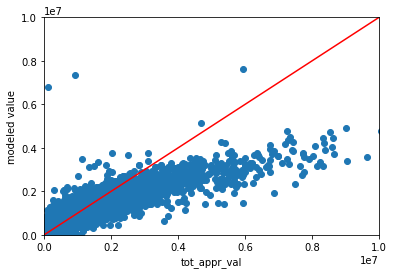

In [ ]:
y_val_pred = ridg.predict(X_val_test_scaled_df)
# Let's plot the predictions against the actual result. Use scatter()
plt.scatter(y_val_test_df['tot_appr_val'],y_val_pred)
plt.ylim(0,10000000)
plt.xlim(0,10000000)
plt.xlabel('tot_appr_val')
plt.ylabel('modeled value')
plt.plot([3,1000000,25000000],[3,1000000,25000000],color='red')
plt.show()

In [ ]:
print('Root Mean Squared Error for this model is: '+str(mean_squared_error(y_val_test_df['tot_appr_val'],y_val_pred, squared=False)))

Root Mean Squared Error for this model is: 4352357.061531916


This model performs slightly worse than the simple linear model (its RMSE is slightly higher). It also performs badly on the more expensive properties.

## Ridge Regression with varaible Alphas

One more try to see if I can improve Ridge Regression by changing the alpha parameter to penalize corrolated variables more.

In [ ]:

param_grid = {'alpha':[.01,1,10,100,1000]}
ridg2 = linear_model.Ridge(random_state=42)
ridg2_cv= RandomizedSearchCV(ridg2,param_grid,cv=5)
ridg2_cv.fit(X_val_train_scaled_df,y_val_train_df['tot_appr_val'])
print(ridg2_cv.best_score_)
print(ridg2_cv.best_params_);

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


0.7796279975585374
{'alpha': 10}


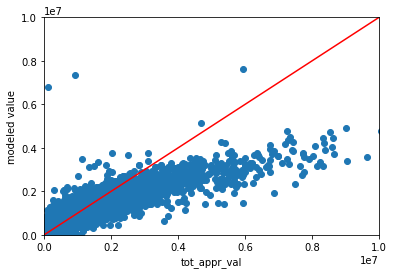

In [ ]:
y_val_pred = ridg2_cv.predict(X_val_test_scaled_df)
# Let's plot the predictions against the actual result. Use scatter()
plt.scatter(y_val_test_df['tot_appr_val'],y_val_pred)
plt.ylim(0,10000000)
plt.xlim(0,10000000)
plt.xlabel('tot_appr_val')
plt.ylabel('modeled value')
plt.plot([3,1000000,25000000],[3,1000000,25000000],color='red')
plt.show()

In [ ]:
print('Root Mean Squared Error for this model is: '+str(mean_squared_error(y_val_test_df['tot_appr_val'],y_val_pred, squared=False)))

Root Mean Squared Error for this model is: 4352868.352978608


This is even slightly worse than the first ridge model's performance. We are moving the wrong direction with these models.

## Linear regression with best* number of columns

Going back to the previous best model (linear) I'm going to utilize SelectKBest to train the model using the best number of columns.

In [ ]:
#Lets take a look to see if there are columns that are not helping with the modeling. Based on the workflow from the guided capstone. 
pipe = make_pipeline(SelectKBest(score_func= f_regression),linear_model.LinearRegression())
pipe.fit(X_val_train_scaled_df,y_val_train_df['tot_appr_val'])
y_tr_pred = pipe.predict(X_val_train_scaled_df)
y_te_pred = pipe.predict(X_val_test_scaled_df)
r2_score(y_val_train_df['tot_appr_val'], y_tr_pred), r2_score(y_val_test_df['tot_appr_val'], y_te_pred)

(0.7222052879073132, 0.7186330109543174)

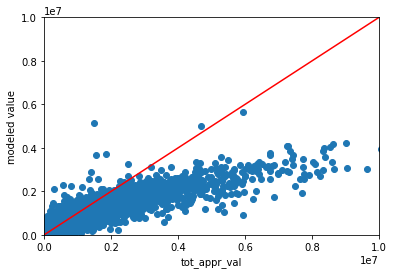

In [ ]:
# Let's plot the predictions against the actual result. Use scatter()
plt.scatter(y_val_test_df['tot_appr_val'],y_te_pred)
plt.ylim(0,10000000)
plt.xlim(0,10000000)
plt.xlabel('tot_appr_val')
plt.ylabel('modeled value')
plt.plot([3,1000000,25000000],[3,1000000,25000000],color='red')
plt.show()

In [ ]:
print('Root Mean Squared Error for this model is: '+str(mean_squared_error(y_val_test_df['tot_appr_val'],y_te_pred, squared=False)))

Root Mean Squared Error for this model is: 167434.3080171558


This model looks to be a significant improvement in RMSE despite visually not looking as though it has improved much. I'm curious based on this which columns are making an impact.

## Evaluating column strength

I next want to try a Random Forest Regressor, but with all columns for this dataset the fit step kept failing after several hours. I am going to decrease the number of columns to the columns that showed as most impactful in the following step in my random forest model.

In [ ]:
#Also following the example from the guided capstone.
k = [k+1 for k in range(len(X_val_train_scaled_df.columns))]
grid_params = {'selectkbest__k': k}
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_val_train_scaled_df, y_val_train_df['tot_appr_val'])
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]
lr_grid_cv.best_params_

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'selectkbest__k': 32}

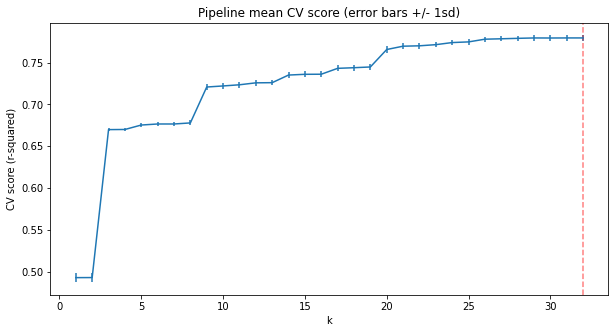

In [ ]:
#plot of the CV score as each new feature is added to the model.
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [ ]:
#It looks like the first 9 variables are providing most of the uplift. I wonder what they are?
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_val_train_scaled_df.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False).head(9)

bld_ar                          196481.715327
FXT                              95616.844765
land_factor_Neighborhood_Grp     83342.560572
bld_val_per_ft2                  80786.823046
bld_factor_Market_Area_1         52032.639210
land_factor_Market_Area_1        44649.867188
land_factor_school_dist          23954.005715
land_factor_Market_Area_2        23756.020628
land_ar                          21106.014048
dtype: float64

It seems interesting that the highest influence are 1) the size of the home, 2) how many rooms the home has, 3) which neighborhood group the properties land is in. With just these 3 we are at .67 of the variance explained which is impressive since the other 29 columns only gets the model .78. The other important factors seem to be land location related.

## RandomForestRegressor with 9 highest influence

Now with only the nine most influential columns I'll see if the random forest regressor performs any better.

In [ ]:
cols_to_keep = ['bld_ar','FXT ','land_factor_Neighborhood_Grp','bld_val_per_ft2','bld_factor_Market_Area_1','land_factor_Market_Area_1','land_factor_school_dist','land_factor_Market_Area_2','land_ar']
X_val_train_red = X_val_train_scaled_df[cols_to_keep]

In [ ]:
RF_reg = RandomForestRegressor(random_state=47)
RF_reg.fit(X_val_train_red,y_val_train_df['tot_appr_val'])
RF_reg.score(X_val_train_red,y_val_train_df['tot_appr_val'])

0.9964663497295446

Well that seems like an extreamly good fit to the training dataset... time to see how it generalizes.

In [ ]:
X_val_test_red = X_val_test_scaled_df[cols_to_keep]
y_tr_pred = RF_reg.predict(X_val_train_red)
y_tst_pred = RF_reg.predict(X_val_test_red)
r2_score(y_val_train_df['tot_appr_val'], y_tr_pred), r2_score(y_val_test_df['tot_appr_val'], y_tst_pred)

(0.9964663497295445, 0.974500867057765)

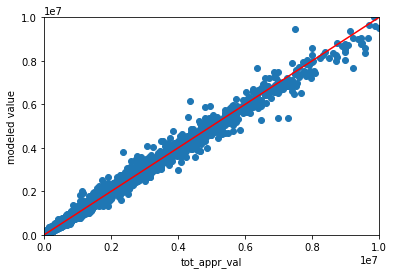

In [ ]:
# Let's plot the training predictions against the actual result. Use scatter()
plt.scatter(y_val_train_df['tot_appr_val'],y_tr_pred)
plt.ylim(0,10000000)
plt.xlim(0,10000000)
plt.xlabel('tot_appr_val')
plt.ylabel('modeled value')
plt.plot([3,1000000,25000000],[3,1000000,25000000],color='red')
plt.show()

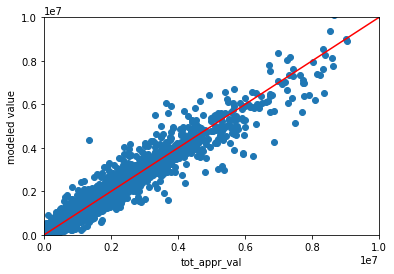

In [ ]:
# Let's plot the test predictions against the actual result. Use scatter()
plt.scatter(y_val_test_df['tot_appr_val'],y_tst_pred)
plt.ylim(0,10000000)
plt.xlim(0,10000000)
plt.xlabel('tot_appr_val')
plt.ylabel('modeled value')
plt.plot([3,1000000,25000000],[3,1000000,25000000],color='red')
plt.show()

In [ ]:
print('Root Mean Squared Error for this model is: '+str(mean_squared_error(y_val_test_df['tot_appr_val'],y_tst_pred, squared=False)))

Root Mean Squared Error for this model is: 50404.648048785755


This Random Forest Regressor is by far the best model so far visually it does a good job of predicting the test data even at higher values. With a RMSE that is a third of the next best model this is the model I would move forward with at this time. This model seems to do a good job of predicting single family home values.

# **Protest Prediction**

In the second section of this project is to identify if I can predict which properties are likely to file a protest.

I actually need to drop a couple additional columns from the X data after I realized that these catagorical columns would 100% correlate with properties that had a protest.

In [ ]:
#need to drop a couple catigorical columns that only have a value if there was a protest...
X_hear_train_scaled_df = X_hear_train_scaled_df.drop(columns=['Hearing_Type_I','Hearing_Type_N','Hearing_Type_R','Agent_Code_Owner '])
X_hear_test_scaled_df = X_hear_test_scaled_df.drop(columns=['Hearing_Type_I','Hearing_Type_N','Hearing_Type_R','Agent_Code_Owner '])

KeyError: ignored

## Default Entropy Decision Tree

The first model that I will attempt is a Decision Tree Classifier to establish a baseline.

In [ ]:
#Time to start working at figuring out if I can correctly classify which properties are more likely to protest.
#some of the following workflow and code is based on https://github.com/K-Wolfe-hub/Springboard/blob/fb65c2302b657ae94cff01066a32b5c1bacb4d8f/Decision_Trees/Springboard%20Decision%20Tree%20Specialty%20Coffee%20Case%20Study%20-%20Tier%203.ipynb
dtc_simple = tree.DecisionTreeClassifier(criterion='entropy',random_state=1234)
dtc_simple.fit(X_hear_train_scaled_df,y_hear_train_df['protested_Y']) 
y_pred = dtc_simple.predict(X_hear_test_scaled_df) 
pd.Series(y_pred)

0         0
1         1
2         0
3         0
4         0
         ..
349399    0
349400    0
349401    0
349402    0
349403    0
Length: 349404, dtype: int64

In [ ]:
print("Model Entropy - no max depth")
print("Accuracy:", metrics.accuracy_score(y_hear_test_df['protested_Y'],y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_hear_test_df['protested_Y'],y_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_hear_test_df['protested_Y'],y_pred, pos_label = 1))
print('Precision score for "No"' , metrics.precision_score(y_hear_test_df['protested_Y'],y_pred, pos_label = 0))
print('Recall score for "Yes"' , metrics.recall_score(y_hear_test_df['protested_Y'],y_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_hear_test_df['protested_Y'],y_pred, pos_label = 0))

Model Entropy - no max depth
Accuracy: 0.8567703861432611
Balanced accuracy: 0.8207715852139422
Precision score for "Yes" 0.7385104327866809
Precision score for "No" 0.9017544968611849
Recall score for "Yes" 0.7408881572092442
Recall score for "No" 0.9006550132186403


This model looks to have done a good job of predicting protests. Precision and Recall for "Yes" is the most interesting measure of performance to me as Precision is telling me what proportion of my predicted protests actually protested and Recall is what proportion of my actual protests did I correctly predict. This model seems well balanced in I fail to correctly predict about as many actual protests as I predict protests that didn't happen (see confusion matrix below).

In [ ]:
confusion_matrix = pd.crosstab(y_hear_test_df['protested_Y'],y_pred, rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted       0      1
Actual                  
0          228253  25177
1           24868  71106


In [ ]:
dtc_simple.get_depth()

84

## Gini GridSearchCV Decision Tree, multi depth, multi min_samples_leaf

Using GridSearchCV I'll see if I can improve the Decision Tree Model.

In [ ]:
'''#I wonder how much better we can do
para = {'criterion':['gini'], 'max_depth':np.arange(2,30),'min_samples_leaf':[0.01,0.02,0.05,0.1]}
dtc = tree.DecisionTreeClassifier(random_state=1234)
dtc_cv = GridSearchCV(dtc,para,cv=5)
dtc_cv.fit(X_hear_train_scaled_df,y_hear_train_df['protested_Y']) 
y_pred2 = dtc_cv.predict(X_hear_test_scaled_df) 
print(dtc_cv.best_params_)
print("Accuracy:", metrics.accuracy_score(y_hear_test_df['protested_Y'],y_pred2))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_hear_test_df['protested_Y'],y_pred2))
print('Precision score for "Yes"' , metrics.precision_score(y_hear_test_df['protested_Y'],y_pred2, pos_label = 1))
print('Precision score for "No"' , metrics.precision_score(y_hear_test_df['protested_Y'],y_pred2, pos_label = 0))
print('Recall score for "Yes"' , metrics.recall_score(y_hear_test_df['protested_Y'],y_pred2, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_hear_test_df['protested_Y'],y_pred2, pos_label = 0))'''

The above took almost 2 hours to run, so I am going to comment it out and just show the results here...

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 0.01} \\
Accuracy: 0.8176666552186008 \\
Balanced accuracy: 0.7264346891040241 \\
Precision score for "Yes" 0.7361664129289144 \\
Precision score for "No" 0.8374731404664665 \\
Recall score for "Yes" 0.5239856627836705 \\
Recall score for "No" 0.9288837154243775 \\

It looks like this model performs close to as well for Precision but in Recall fails to meet the performance of the entropy model with default parameters. 

The below is the model with the best params from the GridSearchCV that was commented out.

In [ ]:
#Best model from above
dtc_gini8 = tree.DecisionTreeClassifier(criterion='gini',max_depth=8,min_samples_leaf=0.01,random_state=1234)
dtc_gini8.fit(X_hear_train_scaled_df,y_hear_train_df['protested_Y']) 
y_pred8 = dtc_gini8.predict(X_hear_test_scaled_df) 
confusion_matrix = pd.crosstab(y_hear_test_df['protested_Y'],y_pred8, rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted       0      1
Actual                  
0          235407  18023
1           45685  50289


In [ ]:
feat_imp = pd.DataFrame(zip(X_hear_train_scaled_df.columns,dtc_gini8.feature_importances_))
feat_imp.sort_values(by=1,ascending=False).head(10)

,0,1
5,x_features_val,0.363487
47,tot_appr_val_inc,0.332999
11,prior_x_features_val,0.103971
15,tot_rcn_val,0.045507
12,prior_tot_appr_val,0.041963
48,Cap_acct_Y,0.040023
40,bld_val_per_ft2,0.039964
44,bld_factor_Market_Area_1,0.007829
14,new_construction_val,0.007303
42,bld_factor_Neighborhood_Code,0.005766


It looks like the value of the additional features (things like pools) seem to be a potential trigger for protests. Not supprisingly tot_appr_val_inc seems to also be one of the primary drivers in this model.

## Default RandomForestClassifier

Looking to improve this model I am going to next use a Random Forest Classifier to see if it will do better at predicting protests than the Default Decision Tree above.

In [ ]:
rft_simple = RandomForestClassifier(random_state=1234)
rft_simple.fit(X_hear_train_scaled_df,y_hear_train_df['protested_Y']) 
y_pred_rft = rft_simple.predict(X_hear_test_scaled_df) 


In [ ]:
print("Random Forest Model- Default params - no max depth")
print("Accuracy:", metrics.accuracy_score(y_hear_test_df['protested_Y'],y_pred_rft))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_hear_test_df['protested_Y'],y_pred_rft))
print('Precision score for "Yes"' , metrics.precision_score(y_hear_test_df['protested_Y'],y_pred_rft, pos_label = 1))
print('Precision score for "No"' , metrics.precision_score(y_hear_test_df['protested_Y'],y_pred_rft, pos_label = 0))
print('Recall score for "Yes"' , metrics.recall_score(y_hear_test_df['protested_Y'],y_pred_rft, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_hear_test_df['protested_Y'],y_pred_rft, pos_label = 0))

Random Forest Model- Default params - no max depth
Accuracy: 0.9167983194239333
Balanced accuracy: 0.8702956693259484
Precision score for "Yes" 0.9163689772345378
Precision score for "No" 0.9169265190680249
Recall score for "Yes" 0.7671035905557755
Recall score for "No" 0.9734877480961213


This model does extremely well at Precision only predicting 6719 properties to protest that did not actually protest. For Recall, this model does slightly better than the Default Decisions Tree making this the currently leading model.

In [ ]:
confusion_matrix = pd.crosstab(y_hear_test_df['protested_Y'],y_pred_rft, rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted       0      1
Actual                  
0          246711   6719
1           22352  73622


In [ ]:
feat_imp = pd.Series(rft_simple.feature_importances_, index = X_hear_train_scaled_df.columns).sort_values(ascending = False)
feat_imp[:10]

x_features_val             0.112850
tot_appr_val_inc           0.094914
Initial_Market_Value       0.072984
Initial_Appraised_Value    0.055014
prior_x_features_val       0.052525
assessed_val               0.050303
tot_mkt_val                0.048859
tot_appr_val               0.044126
bld_val_per_ft2            0.035805
tot_rcn_val                0.033834
dtype: float64

It appears that x_features_val and tot_appr_val_inc remain highly influential in this model, but less impactful than in the Decision Trees.

I am curious about the population that I am predicting to have not protested but did. The next few graphs are looking at the difference between the different groups in the confusion matrix.

<Figure size 1080x864 with 0 Axes>

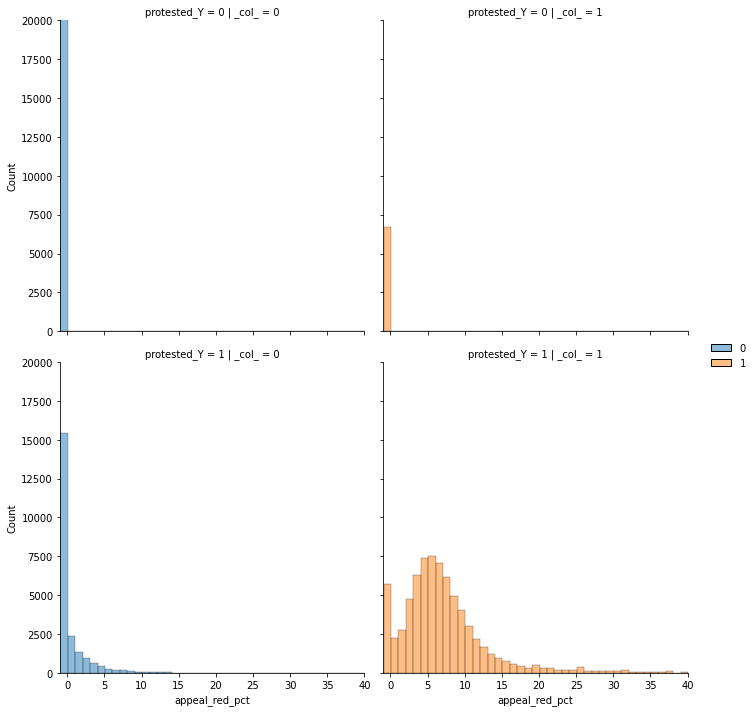

In [ ]:
plt.figure(figsize=(15,12))
sns.displot(x=y_hear_test_df['appeal_red_pct'],col=y_pred_rft,row=y_hear_test_df['protested_Y'],binwidth=1,hue=y_pred_rft)
plt.ylim(0,20000)
plt.xlim(-1,40)
plt.show()

<Figure size 1080x864 with 0 Axes>

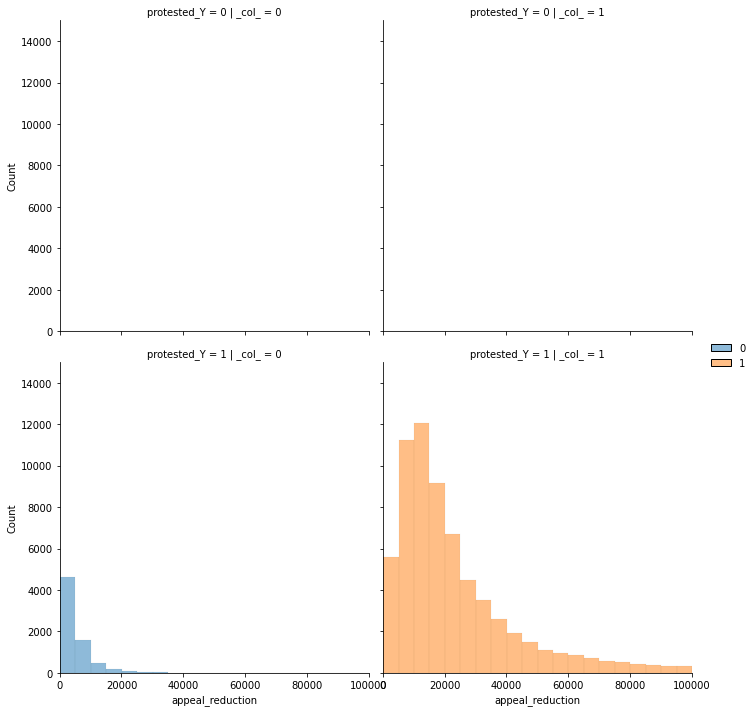

In [ ]:
plt.figure(figsize=(15,12))
sns.displot(x=y_hear_test_df['appeal_reduction'],col=y_pred_rft,row=y_hear_test_df['protested_Y'],binwidth=5000,hue=y_pred_rft)
plt.ylim(0,15000)
plt.xlim(-1,100000)
plt.show()

The two plots above show that the false negatives are the less succesful protests (they maybe should not have protested).

It looks as though this default random forest model is getting 3/4 of the protested properties corretly predicted. This really is doing pretty well based on the random nature of humans. There will always be some people who protest who have no reason to and some who should protest who won't bother. If the differences in results for homes that this model sugests would protest holds for the properties that did not protest but were predicted to protest, these ~7000 could potentially see a reduction in their property taxes.

## GridSearch RandomForest, variable n_estimaters, max_depth,  min_sameles_leaf

Like with the Decision Tree I next tried to improve on the RandomForest above by running a gridsearch.

In [ ]:
'''para = {'n_estimators':[50,100],'min_samples_split':[2,4,6], 'max_samples':[50000,100000]}
rft = RandomForestClassifier(random_state=1234)
rft_cv = GridSearchCV(rft,para,cv=5,n_jobs = -1)
rft_cv.fit(X_hear_train_scaled_df,y_hear_train_df['protested_Y']) 
y_pred_cv = rft_cv.predict(X_hear_test_scaled_df) '''

In [ ]:
'''print("Random Forest Model- Best params")
print(rft_cv.best_params_)
print("Accuracy:", metrics.accuracy_score(y_hear_test_df['protested_Y'],y_pred_cv))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_hear_test_df['protested_Y'],y_pred_cv))
print('Precision score for "Yes"' , metrics.precision_score(y_hear_test_df['protested_Y'],y_pred_cv, pos_label = 1))
print('Precision score for "No"' , metrics.precision_score(y_hear_test_df['protested_Y'],y_pred_cv, pos_label = 0))
print('Recall score for "Yes"' , metrics.recall_score(y_hear_test_df['protested_Y'],y_pred_cv, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_hear_test_df['protested_Y'],y_pred_cv, pos_label = 0))'''

The above took an hour to run and is actually less of a range in hyperparameters than I would have liked to have done. Like I did above I have commented it out and just show the results here...

Random Forest Model- Best params
{'max_samples': 100000, 'min_samples_split': 2, 'n_estimators': 100} \\
Accuracy: 0.9027028883470137 \\
Balanced accuracy: 0.8470749987521323 \\
Precision score for "Yes" 0.902862640076961 \\
Precision score for "No" 0.9026577902393552 \\
Recall score for "Yes" 0.723633484068602 \\
Recall score for "No" 0.9705165134356627

The below is the model with the best params from the GridSearchCV that was commented out.

In [ ]:
rft_updated = RandomForestClassifier(random_state=1234,n_estimators=100,min_samples_split=2,max_samples=100000,n_jobs=-1)
rft_updated.fit(X_hear_train_scaled_df,y_hear_train_df['protested_Y']) 
y_pred_rftup = rft_updated.predict(X_hear_test_scaled_df) 

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_hear_test_df['protested_Y'],y_pred_rftup))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_hear_test_df['protested_Y'],y_pred_rftup))
print('Precision score for "Yes"' , metrics.precision_score(y_hear_test_df['protested_Y'],y_pred_rftup, pos_label = 1))
print('Precision score for "No"' , metrics.precision_score(y_hear_test_df['protested_Y'],y_pred_rftup, pos_label = 0))
print('Recall score for "Yes"' , metrics.recall_score(y_hear_test_df['protested_Y'],y_pred_rftup, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_hear_test_df['protested_Y'],y_pred_rftup, pos_label = 0))

Accuracy: 0.9027028883470137
Balanced accuracy: 0.8470749987521323
Precision score for "Yes" 0.902862640076961
Precision score for "No" 0.9026577902393552
Recall score for "Yes" 0.723633484068602
Recall score for "No" 0.9705165134356627


In [ ]:
confusion_matrix = pd.crosstab(y_hear_test_df['protested_Y'],y_pred_rftup, rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted       0      1
Actual                  
0          245958   7472
1           26524  69450


This model is only slightly worse than the default RandomForestClassifier's performance on Precision. Its Recall is also just slightly worse. The Default Random Forest Classifier is my current best model for Protest Prediction.

#Thoughts

The Total Appriasal value prediction model does a decent job of prediction, but I feel like an RMSE of >50,000 indicates that this model may not yet be useful for creating an argument within an appeal. the failing of this model is apparent in the fairly significant spread from the 1:1 line in the scatter plot of actual vs predicted on the test data.

With Protest prediction the model appears to have been able to do an excellent job of being correct when predicting a protest. There may be a potential population that would benifit from protesting identified through this model. Recall for this prediction model also seems to be identifying a second population in the group that are not predicted to protest but actually did. This group is of interest because it appears this group is less successful in the results of their protests. If there were a way to incentivise this population not to protest there could be up to a 25% reduction in the number of hearings associated with single family homes. 